<center><b><font size="+2"> CORRELAÇÃO E REGRESSÃO COM DADOS DE FILMES IMDB </font></b>


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib

from biokit.viz import corrplot
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df_credits = pd.read_csv(r'C:/Users/juliana/imbd_movies/credits.csv')
df_movies = pd.read_csv(r'C:/Users/juliana/imbd_movies/movies_metadata.csv')

In [6]:
def removeTextRows(df, columnName):
    index_0=[]
    
    for i in df.itertuples():
        myValue = getattr(i, columnName)
        if(str.isdigit(myValue)):
            index_0.append(i.Index)

    df=df.loc[index_0] 
    df.reset_index(level=0, inplace=True)
    return df   

In [7]:
df_credits['id'] = df_credits['id'].astype('string')
df_movies['id'] = df_movies['id'].astype('string')
df_movies['budget'] = df_movies['budget'].astype('string')

df_movies = removeTextRows(df_movies,'budget')

df_movies['budget']=pd.to_numeric(df_movies['budget'])
df_movies['popularity']=pd.to_numeric(df_movies['popularity'])

df_movies = df_movies.merge(df_credits,on='id')
del df_credits

df_movies = df_movies[['budget', 'popularity', 'revenue', 'runtime','vote_average', 'vote_count']]
df_movies.dropna(inplace=True)

<h2> Correlação </h2>

C:\Users\JULIAN~1.PER\AppData\Local\Temp/ipykernel_2860/2042593155.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(matriz_corr, dtype=np.bool))


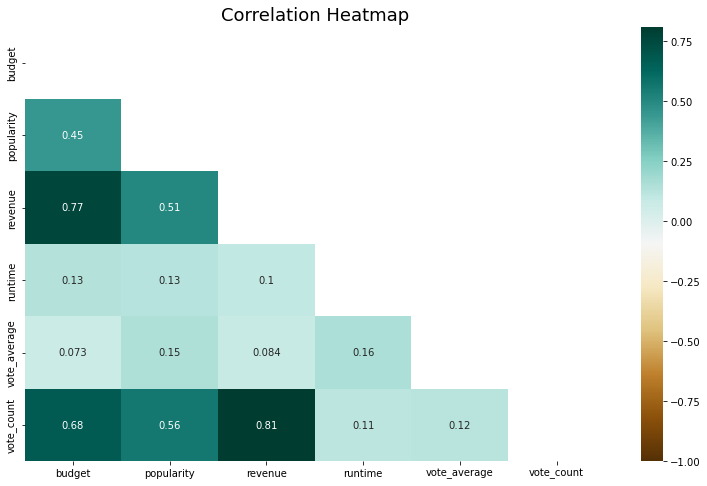

In [8]:
plt.figure(figsize=(13, 8))

#grafico_corr=corrplot.Corrplot(matriz_corr)
#grafico_corr.plot()
#plt.gcf().set_size_inches(13,8)

matriz_corr=df_movies.corr()
mask = np.triu(np.ones_like(matriz_corr, dtype=np.bool))
hm = sns.heatmap(matriz_corr, mask=mask, vmin=-1, annot=True, cmap='BrBG')
hm.set_title('Correlation Heatmap', fontdict={'fontsize':18})
plt.show()


<h2> Regressões </h2>

In [9]:
X = df_movies[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']]
y = df_movies['revenue']

<h3> Regressão Linear Múltipla</h3>

In [10]:
# LINEAR 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
    
mse_multipla = mean_squared_error(y_test, y_pred_test)
rmse_multipla = np.sqrt(mse_multipla)
mae_multipla = mean_absolute_error(y_test,y_pred_test)
r2_multipla = r2_score(y_test, y_pred_test)

print('MAE:', mae_multipla)
print('MSE:', mse_multipla)
print('RMSE:', rmse_multipla)
print('R²:', r2_multipla)


MAE: 9737606.273367656
MSE: 962228034085795.5
RMSE: 31019800.677725114
R²: 0.7052517397559228


<h3> Regressão de Ridge </h3>

In [11]:
# RIDGE REGRESSION

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

alpha = 1.0 # parâmetro de regularização
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
y_pred = ridge.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred)
mse_ridge = mean_squared_error(y_test, y_pred)

print('R²:', r2_ridge)
print('MSE:', mse_ridge)


R²: 0.7052542987397374
MSE: 962219680089191.4


<h3> Regressão Polinomial</h3>

In [12]:
# POLINOMIAL

r2_scores = []
MSEs = []
for degree in range(1, 6):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    y_pred_train = model.predict(X_poly_train)
    y_pred_test = model.predict(X_poly_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_scores.append((degree, r2_train, r2_test))
    MSE = mean_squared_error(y_test, y_pred_test)
    MSEs.append((degree, MSE))

    
max_r2_degree_train = max(r2_scores, key=lambda x: x[1])[0]
print('O grau que maximiza o R2 no conjunto de treinamento é', max_r2_degree_train)

poly = PolynomialFeatures(degree=max_r2_degree_train)
X_poly = poly.fit_transform(df_movies[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']])

model = LinearRegression()
model.fit(X_poly, df_movies['revenue'])
r2_polinomial = model.score(X_poly, df_movies['revenue'])

print('\n')
print('R²:', r2_polinomial)

O grau que maximiza o R2 no conjunto de treinamento é 2


R²: 0.7963493202259795


<h3> Comparação de resultados </h3>

In [13]:
print('R² REGRESSÃO MÚLTIPLA:', r2_multipla)
print('R² - REGRESSÃO RIDGE:', r2_ridge)
print('R² - REGRESSÃO POLINOMIAL:', r2_polinomial)

R² REGRESSÃO MÚLTIPLA: 0.7052517397559228
R² - REGRESSÃO RIDGE: 0.7052542987397374
R² - REGRESSÃO POLINOMIAL: 0.7963493202259795


<h3> Salvando o modelo da regressão polinomial </h3>

In [17]:
joblib.dump(model, 'C:/Users/juliana/imbd_movies/model.pkl')


<h3> Predizendo a receita com base nas variáveis independentes</h3>

In [15]:
budget_data = df_movies['budget'].mean()
popularity_data = df_movies['popularity'].mean()
runtime_data = df_movies['runtime'].mean()
vote_average_data = df_movies['vote_average'].mean()
vote_count_data = df_movies['vote_count'].mean()

X_new = np.column_stack((budget_data, popularity_data, runtime_data, vote_average_data, vote_count_data))

poly = PolynomialFeatures(degree=max_r2_degree_train)
X_new_poly = poly.fit_transform(X_new)
y_new_pred = model.predict(X_new_poly)

print("Receita prevista:", y_new_pred)

Receita prevista: [11277516.91106535]
